# Exploratory Data Analysis for GCP Dataset

This section focuses on finding insights from the GCP dataset.

## Import Libraries

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
from IPython.display import display, HTML
from matplotlib.colors import LogNorm
from pathlib import Path

In [ ]:
RAW_EXT = Path("../data/raw/external_dataset")
CLE = Path("../data/cleaned")
CUR = Path("../data/curated")

# Clean SA2 Shapefile

In [3]:
# Load the SA2 shapefile
sa2 = gpd.read_file(RAW_EXT / "SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")

In [4]:
# Keep only relevant columns
sa2 = sa2[[
    "SA2_CODE21",  # SA2 unique identifier
    "SA2_NAME21",      # SA2 name
    "STE_CODE21",    # State code
    "STE_NAME21",    # State name
    "geometry"
]]

# Standardise column names
sa2 = sa2.rename(columns={
    "SA2_CODE21": "SA2_code",
    "SA2_NAME21": "SA2_name",
    "STE_CODE21": "state_code",
    "STE_NAME21": "state_name"
})

# Ensure SA2_code is string and zero-padded
sa2["SA2_code"] = sa2["SA2_code"].astype(str).str.zfill(9)

# Drop areas that are not useful (No usual address, Offshore, etc.)
exclude_names = [
    "Migratory - Offshore - Shipping",
    "No usual address"
]
sa2 = sa2[~sa2["SA2_name"].isin(exclude_names)]

# Reset index
sa2 = sa2.reset_index(drop=True)

In [5]:
sa2.head()

,SA2_code,SA2_name,state_code,state_name,geometry
0,101021007,Braidwood,1,New South Wales,"POLYGON ((149.58424 -35.44426, 149.58444 -35.4..."
1,101021008,Karabar,1,New South Wales,"POLYGON ((149.21899 -35.36738, 149.218 -35.366..."
2,101021009,Queanbeyan,1,New South Wales,"POLYGON ((149.21326 -35.34325, 149.21619 -35.3..."
3,101021010,Queanbeyan - East,1,New South Wales,"POLYGON ((149.24034 -35.34781, 149.24024 -35.3..."
4,101021012,Queanbeyan West - Jerrabomberra,1,New South Wales,"POLYGON ((149.19572 -35.36126, 149.1997 -35.35..."


In [6]:
sa2.to_file(CUR / "SA2_shapefile_cleaned/SA2_shapefile_2021_cleaned.shp")

## EDA Cleaned GCP Dataset

In [7]:
gcp = pd.read_csv(CLE / "general_community_profile.csv", dtype={"SA2_code": str})
print(gcp.dtypes)

SA2_code                           object
total_population                  float64
median_weekly_personal_income     float64
median_weekly_household_income    float64
children_0_12                     float64
teenagers_13_19                   float64
youth_20_24                       float64
young_adults_25_34                float64
adults_35_64                      float64
senior_adults_65_plus             float64
full_time_employee_total          float64
part_time_employee_total          float64
unemployed_total                  float64
labour_force_total                float64
not_in_labour_force_total         float64
pct_children                      float64
pct_teenagers                     float64
pct_youth                         float64
pct_young_adults                  float64
pct_adults                        float64
pct_seniors                       float64
pct_full_time                     float64
pct_part_time                     float64
pct_unemployed                    

### Merge Dataset
- Combine geometry (shapefile) with attributes (GCP).
- "left" join keeps all SA2 polygons, even if no attributes are found.

In [8]:
merged = sa2.merge(
    gcp,
    how="left",  
    on="SA2_code"
)

In [9]:
merged.head()

,SA2_code,SA2_name,state_code,state_name,geometry,total_population,median_weekly_personal_income,median_weekly_household_income,children_0_12,teenagers_13_19,...,dependency_ratio,income_per_worker,household_personal_gap,unemployment_rate,full_time_share,part_time_share,youth_x_unemployment,youngshare_x_income,dependency_x_unemployment,hhgap_x_seniors
0,101021007,Braidwood,1,New South Wales,"POLYGON ((149.58424 -35.44426, 149.58444 -35.4...",4343.0,760.0,1429.0,604.0,257.0,...,0.721235,0.363636,1.880263,0.032536,0.558852,0.328230,0.000914,85.047202,0.023466,0.476668
1,101021008,Karabar,1,New South Wales,"POLYGON ((149.21899 -35.36738, 149.218 -35.366...",8517.0,975.0,1989.0,1405.0,703.0,...,0.512602,0.216282,2.040000,0.043922,0.648181,0.248669,0.002656,203.883410,0.022514,0.296766
2,101021009,Queanbeyan,1,New South Wales,"POLYGON ((149.21326 -35.34325, 149.21619 -35.3...",11342.0,996.0,1703.0,1552.0,617.0,...,0.459081,0.152714,1.709839,0.041398,0.652101,0.254370,0.002515,268.451067,0.019005,0.275124
3,101021010,Queanbeyan - East,1,New South Wales,"POLYGON ((149.24034 -35.34781, 149.24024 -35.3...",5085.0,1104.0,1796.0,712.0,262.0,...,0.390026,0.363996,1.626812,0.035608,0.676558,0.237389,0.002402,311.985841,0.013888,0.205071
4,101021012,Queanbeyan West - Jerrabomberra,1,New South Wales,"POLYGON ((149.19572 -35.36126, 149.1997 -35.35...",12744.0,1357.0,3014.0,2331.0,1305.0,...,0.451543,0.179331,2.221076,0.022466,0.669486,0.256641,0.001315,237.347222,0.010144,0.213324


## Basic summary statistics

### Row and column counts

In [10]:
print("Number of rows:", len(merged))
print("Number of columns:", len(merged.columns))

Number of rows: 2473
Number of columns: 40


### Schema (data types of each feature)

In [11]:
print("\nSchema:")
print(merged.dtypes)


Schema:
SA2_code                            object
SA2_name                            object
state_code                          object
state_name                          object
geometry                          geometry
total_population                   float64
median_weekly_personal_income      float64
median_weekly_household_income     float64
children_0_12                      float64
teenagers_13_19                    float64
youth_20_24                        float64
young_adults_25_34                 float64
adults_35_64                       float64
senior_adults_65_plus              float64
full_time_employee_total           float64
part_time_employee_total           float64
unemployed_total                   float64
labour_force_total                 float64
not_in_labour_force_total          float64
pct_children                       float64
pct_teenagers                      float64
pct_youth                          float64
pct_young_adults                   float64
pc

### Summary statistics
- count = number of non-missing rows (should be 2416 for every SA2).
- unique = number of unique values (only meaningful for categorical/string variables, but Pandas shows it for everything if you include="all").
- top = most frequent value (e.g. 0.0 shows many areas have 0 unemployed).
- freq = how often that top value appears.

In [12]:
summary_stats = merged.describe().T
print(summary_stats)

                                 count          mean          std      min  \
total_population                2416.0  10522.586093  6038.280652  3.00000   
median_weekly_personal_income   2416.0    843.616722   255.086466  0.00000   
median_weekly_household_income  2416.0   1782.597682   570.414772  0.00000   
children_0_12                   2416.0   1657.617136  1096.777312  0.00000   
teenagers_13_19                 2416.0    865.426738   550.839167  0.00000   
youth_20_24                     2416.0    653.755795   477.973193  0.00000   
young_adults_25_34              2416.0   1500.242136  1137.840431  0.00000   
adults_35_64                    2416.0   4033.227235  2307.864851  0.00000   
senior_adults_65_plus           2416.0   1811.892384  1221.652703  0.00000   
full_time_employee_total        2416.0   2936.696192  1801.925542  0.00000   
part_time_employee_total        2416.0   1640.098924   990.243671  0.00000   
unemployed_total                2416.0    267.586093   187.18118

## Exploration

### Feature distributions
Histograms for all numeric columns to check skewness, tails, and clustering

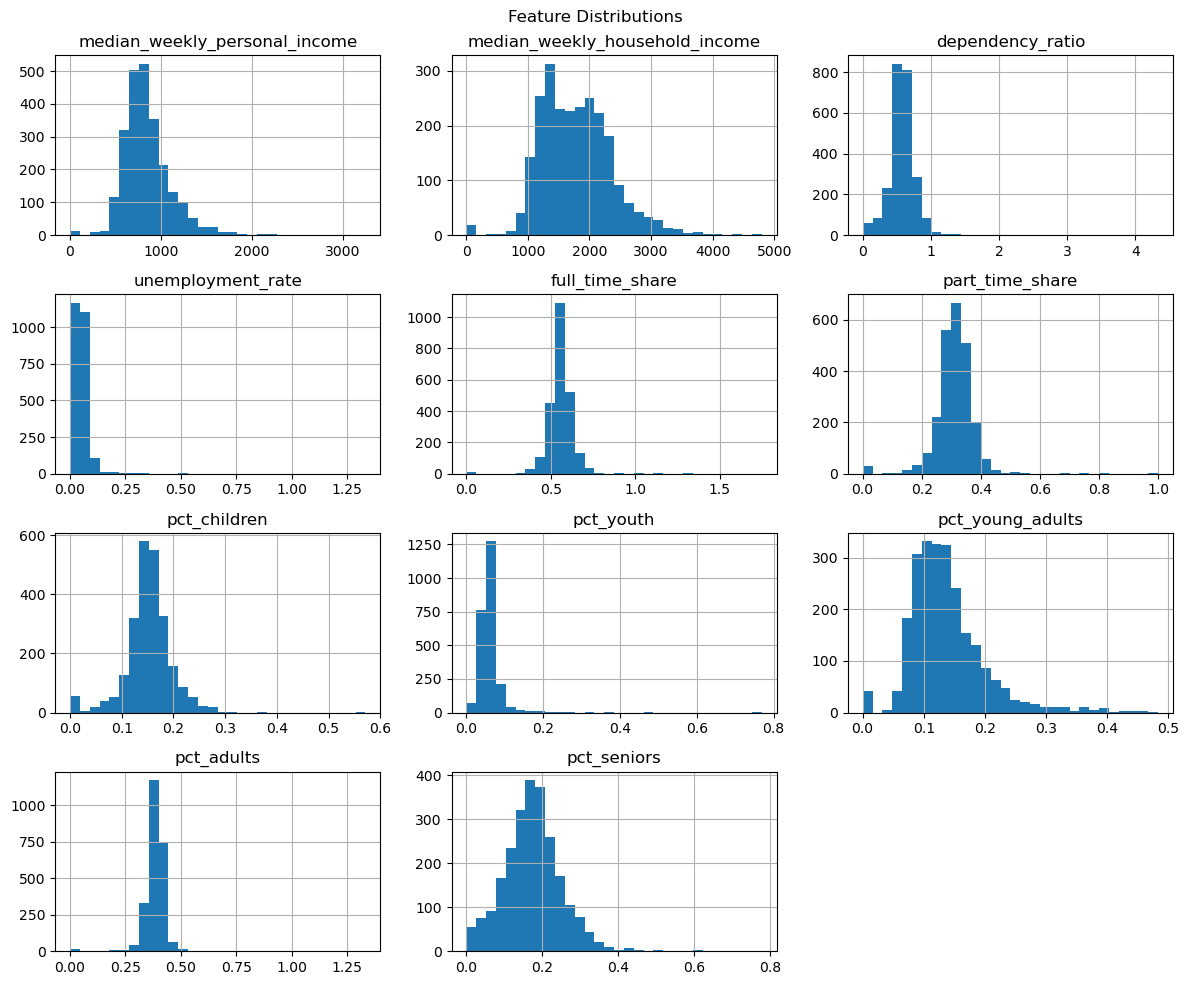

In [13]:
pdf = gcp[
    ["median_weekly_personal_income","median_weekly_household_income",
     "dependency_ratio","unemployment_rate","full_time_share","part_time_share",
     "pct_children","pct_youth","pct_young_adults","pct_adults","pct_seniors"]
]

pdf.hist(figsize=(12,10), bins=30)
plt.suptitle("Feature Distributions")
plt.tight_layout()
plt.show()

### Log transform all the skewed features:
- unemployment_rate
- dependency_ratio
- pct_youth
- pct_young_adults
- pct_seniors

In [14]:
eps = 1e-6
merged["household_personal_gap"] = (
    merged["median_weekly_household_income"] - merged["median_weekly_personal_income"]
)

log_cols = [
    "unemployment_rate",
    "dependency_ratio",
    "pct_youth",
    "pct_young_adults",
    "pct_seniors"
]

for c in log_cols:
    s = pd.to_numeric(merged[c], errors="coerce").fillna(0).clip(lower=0)
    merged[c] = s
    merged[f"{c}_log"] = np.log1p(s + eps)

### Histograms for key numeric columns to check skewness, tails, and clustering (using merged)

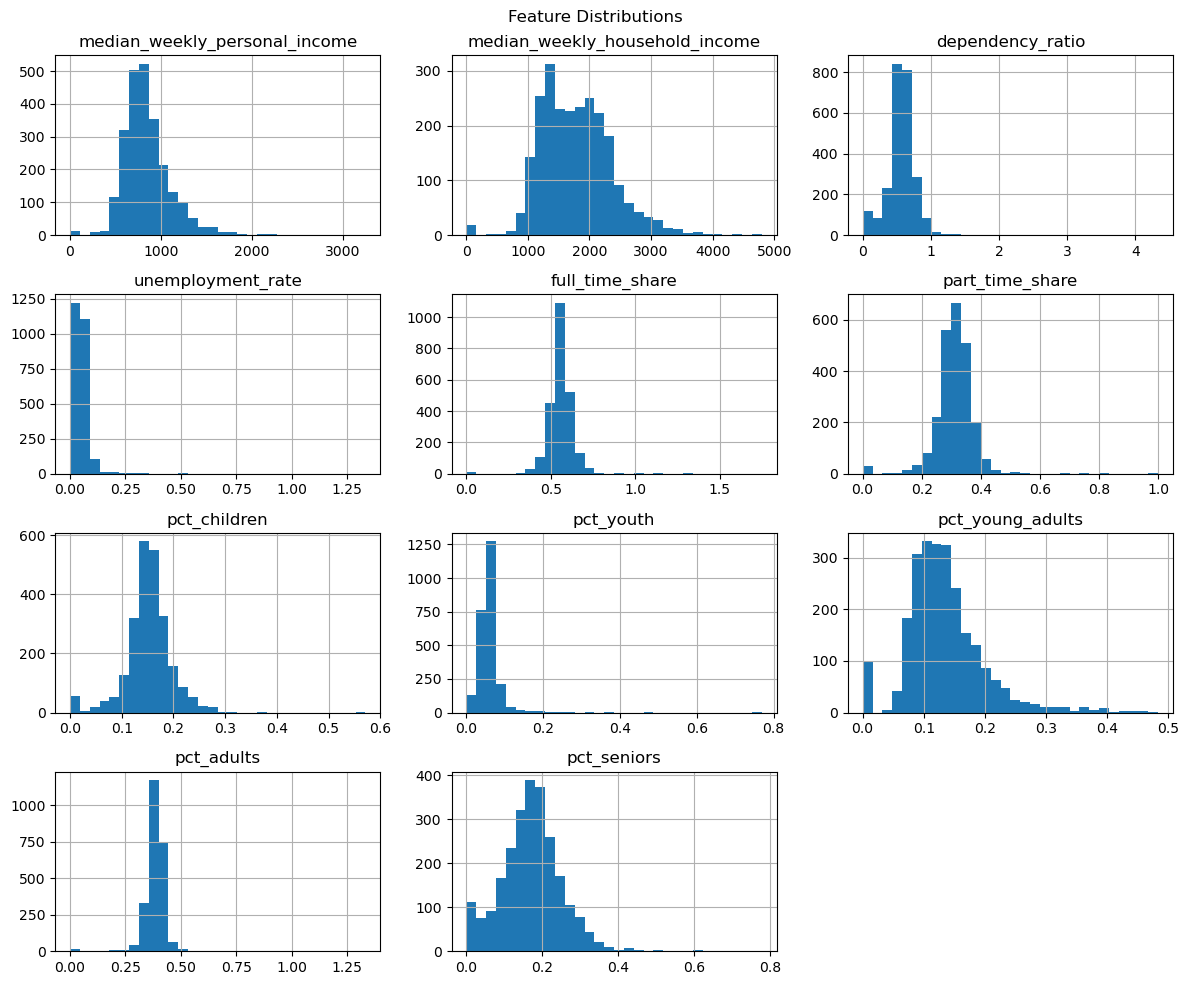

In [15]:
num_cols = [
    "median_weekly_personal_income","median_weekly_household_income",
    "dependency_ratio","unemployment_rate","full_time_share","part_time_share",
    "pct_children","pct_youth","pct_young_adults","pct_adults","pct_seniors"
]
num = merged.loc[:, [c for c in num_cols if c in merged.columns]].copy()

num.hist(figsize=(12,10), bins=30)
plt.suptitle("Feature Distributions")
plt.tight_layout()
plt.show()

### Log transformed feature distribution

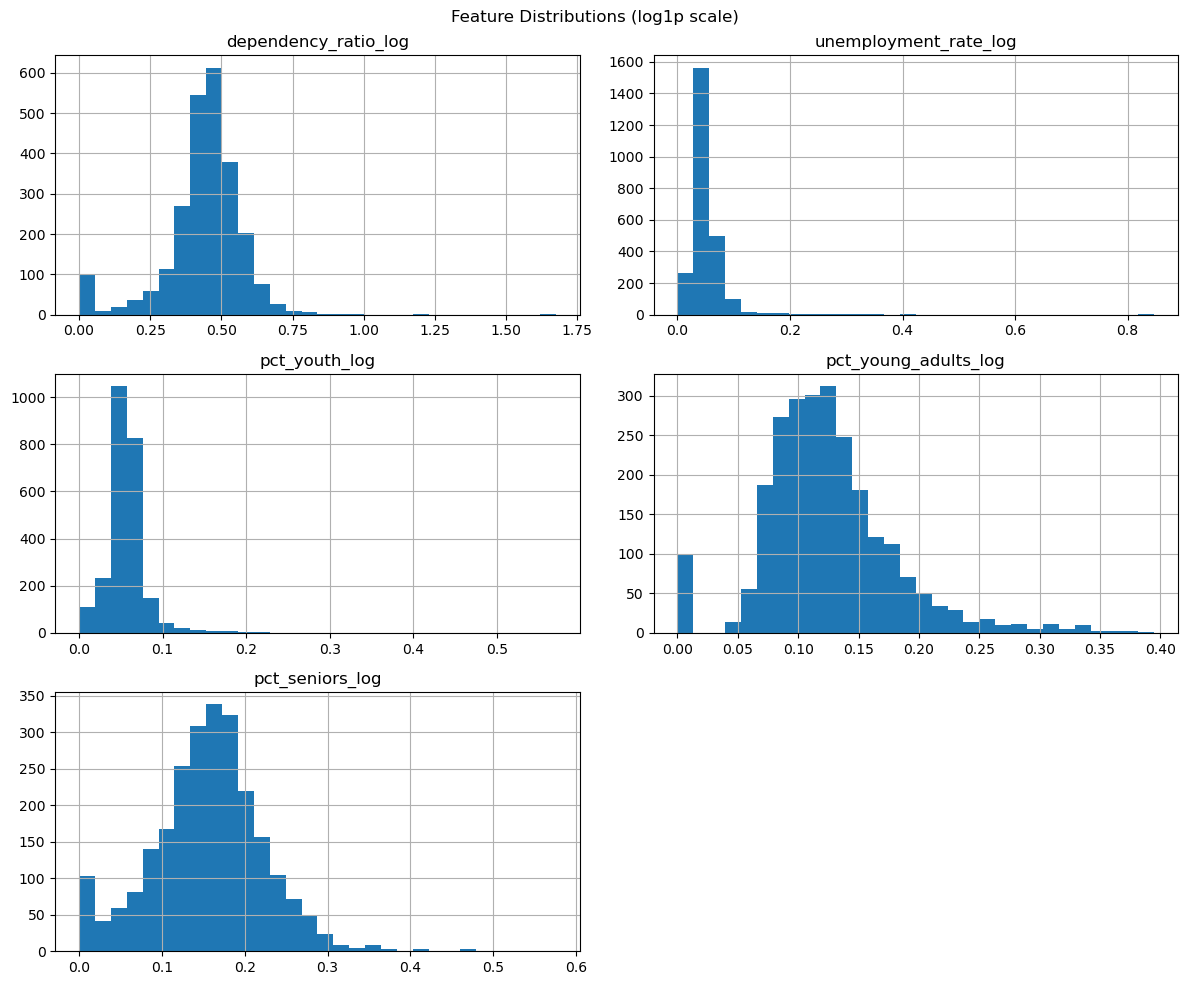

In [16]:
log_view = merged.loc[:, [c for c in [
    "median_weekly_personal_income_log","median_weekly_household_income_log",
    "income_per_worker_log","household_personal_gap_log",
    "dependency_ratio_log","unemployment_rate_log",
    "pct_youth_log","pct_young_adults_log","pct_seniors_log"
] if c in merged.columns]]

log_view.hist(figsize=(12,10), bins=30)
plt.suptitle("Feature Distributions (log1p scale)")
plt.tight_layout()
plt.show()

### Unemployement rate outliers
Visualize identify extreme unemployment pockets

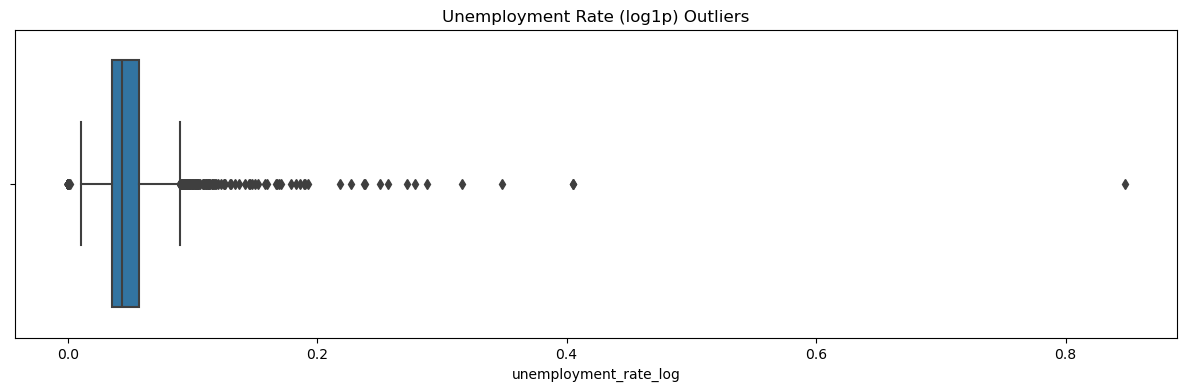

In [17]:
plt.figure(figsize=(15, 4))
sns.boxplot(x=merged["unemployment_rate_log"])
plt.title("Unemployment Rate (log1p) Outliers")
plt.show()

### Feature correlations
Heatmap of pairwise correlations between numeric features

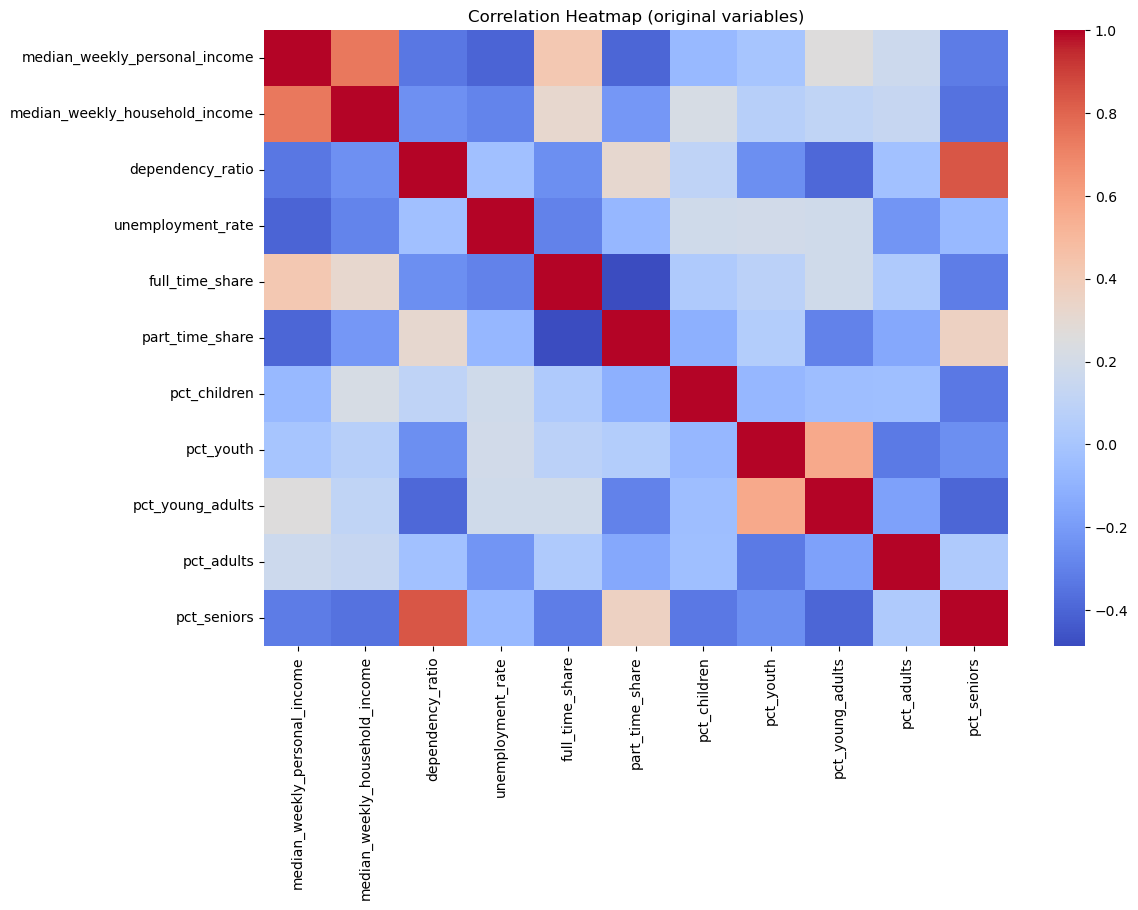

In [18]:
corr = num.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (original variables)")
plt.show()

### Youth vs Unemployement Rate
Tests the hypothesis that youth-heavy SA2s have higher unemployment

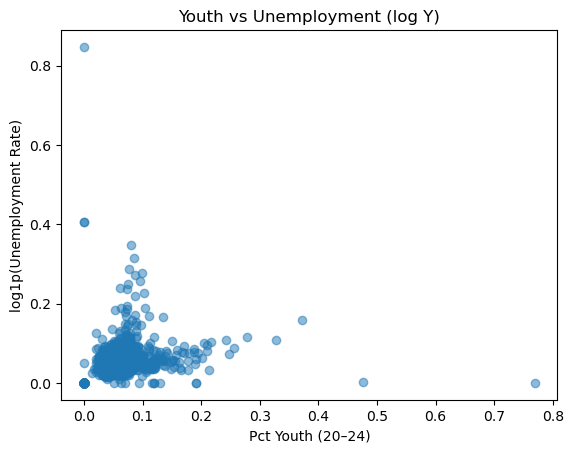

In [19]:
plt.scatter(merged["pct_youth"], merged["unemployment_rate_log"], alpha=0.5)
plt.xlabel("Pct Youth (20–24)")
plt.ylabel("log1p(Unemployment Rate)")
plt.title("Youth vs Unemployment (log Y)")
plt.show()

### Household–Personal Income Gap
- Household gap = household income – personal income
- Checks if senior-heavy SA2s rely more on household-level earnings

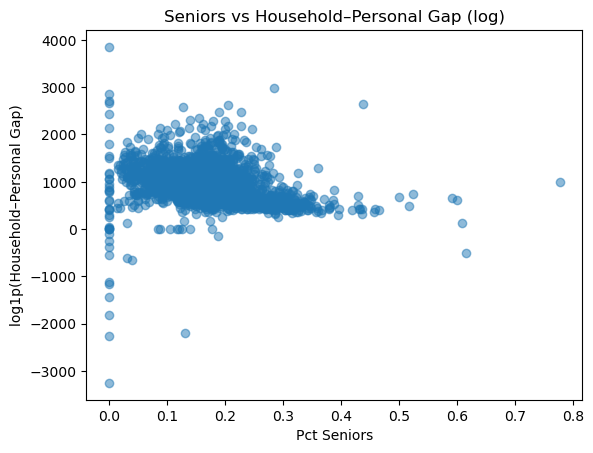

In [20]:
plt.scatter(merged["pct_seniors"], merged["household_personal_gap"], alpha=0.5)
plt.xlabel("Pct Seniors")
plt.ylabel("log1p(Household–Personal Gap)")
plt.title("Seniors vs Household–Personal Gap (log)")
plt.show()

### Income vs unemployment rate
Explores whether low-income areas also have higher unemployment

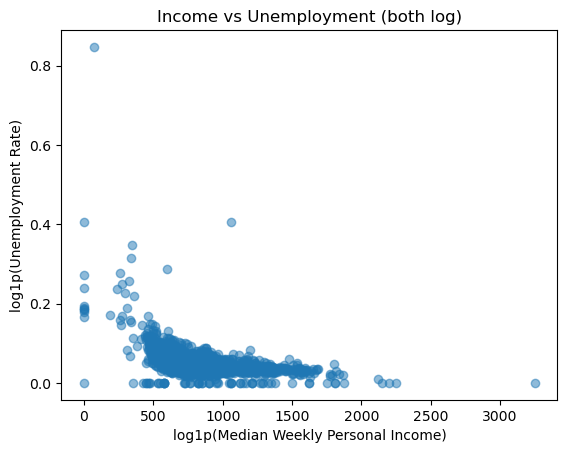

In [21]:
plt.scatter(merged["median_weekly_personal_income"], merged["unemployment_rate_log"], alpha=0.5)
plt.xlabel("log1p(Median Weekly Personal Income)")
plt.ylabel("log1p(Unemployment Rate)")
plt.title("Income vs Unemployment (both log)")
plt.show()

### Income per worker vs not in labour force percentage
Tests whether areas with low productivity/income also have more retirees/students

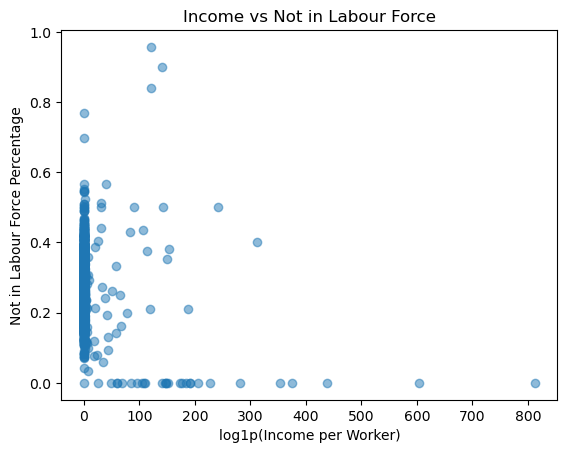

In [22]:
plt.scatter(merged["income_per_worker"], merged["pct_not_in_labour_force"], alpha=0.5)
plt.xlabel("log1p(Income per Worker)")
plt.ylabel("Not in Labour Force Percentage")
plt.title("Income vs Not in Labour Force")
plt.show()

### Outliers

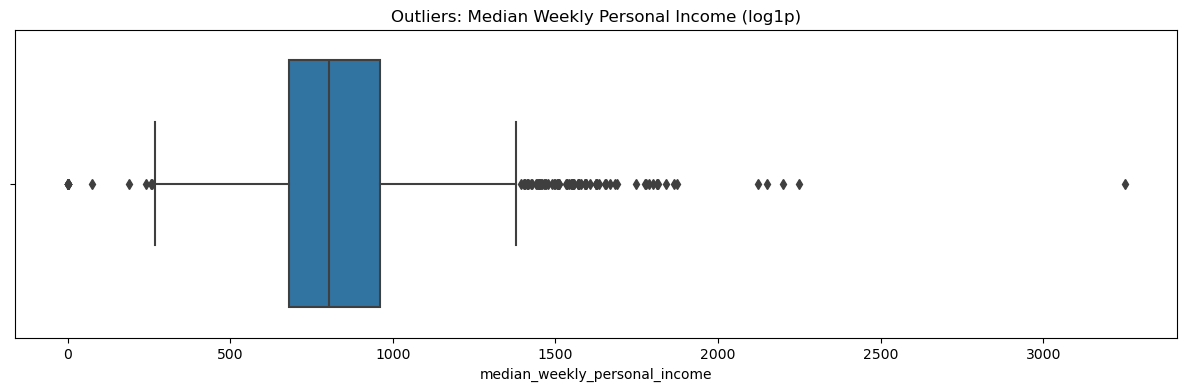

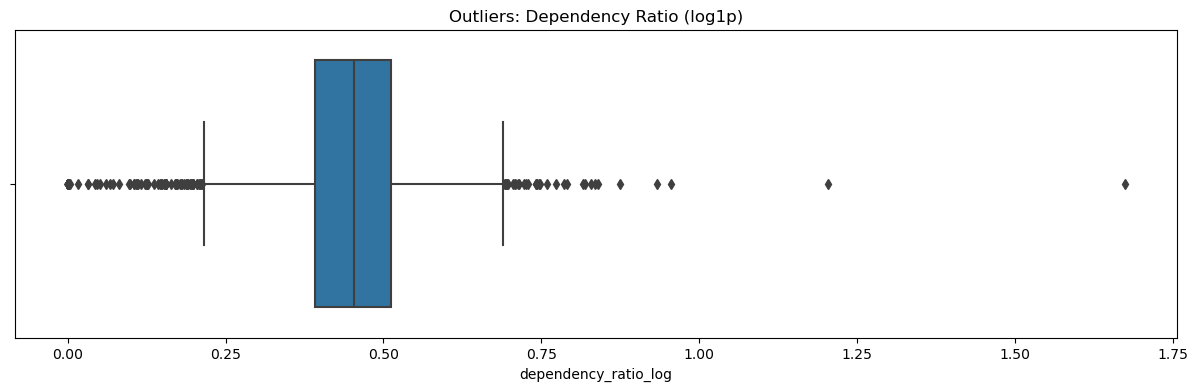

In [23]:
plt.figure(figsize=(15, 4))
sns.boxplot(x=merged["median_weekly_personal_income"])
plt.title("Outliers: Median Weekly Personal Income (log1p)")
plt.show()

plt.figure(figsize=(15, 4))
sns.boxplot(x=merged["dependency_ratio_log"])
plt.title("Outliers: Dependency Ratio (log1p)")
plt.show()

### Geographical patterns 
#### Static map of unemployment rate by SA2

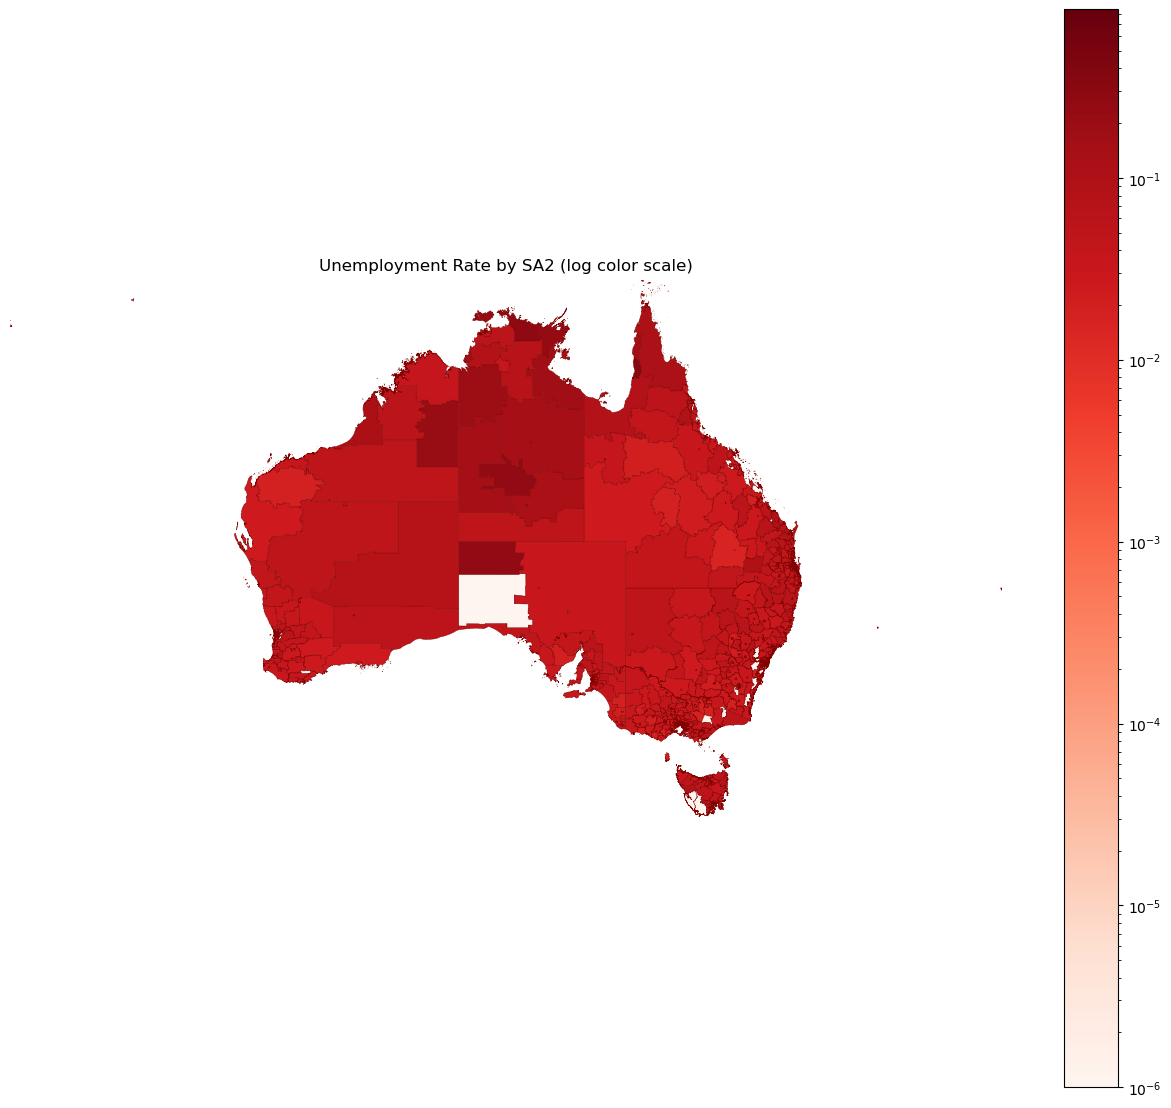

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(16, 14))
vals = pd.to_numeric(merged["unemployment_rate_log"], errors="coerce").fillna(0).clip(lower=eps)
merged.plot(
    column=vals,
    cmap="Reds",
    norm=LogNorm(vmin=max(vals[vals>0].min(), eps), vmax=vals.max()),
    linewidth=0.3,
    edgecolor="maroon",
    legend=True,
    ax=ax
)
ax.set_title("Unemployment Rate by SA2 (log color scale)")
ax.axis("off")
xmin, ymin, xmax, ymax = merged.total_bounds
ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
plt.show()

#### Static map of dependency ratio by SA2

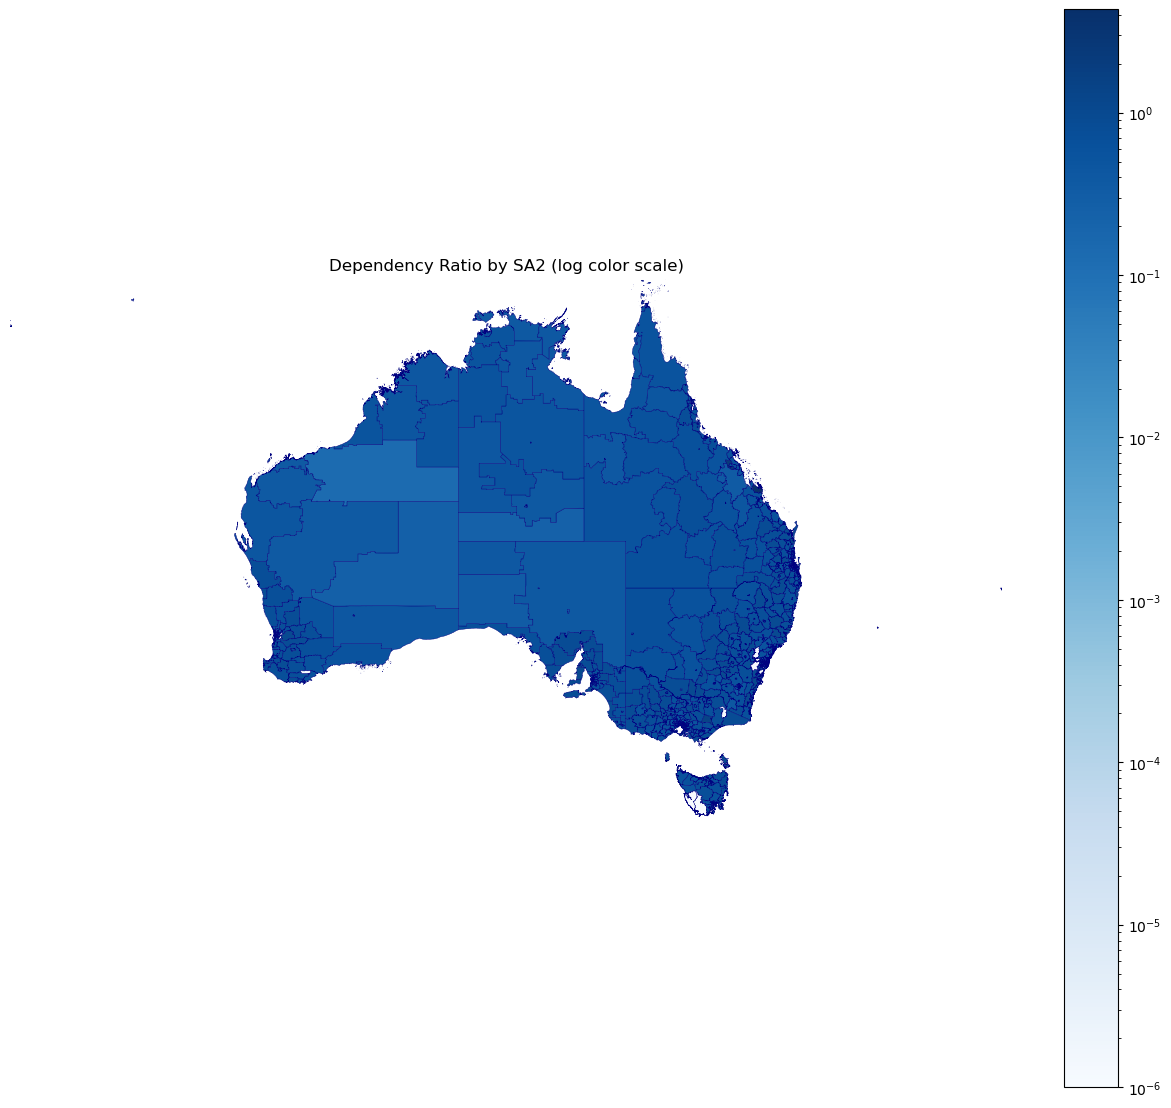

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(16, 14))
vals2 = pd.to_numeric(merged["dependency_ratio"], errors="coerce").fillna(0).clip(lower=eps)
merged.plot(
    column=vals2, cmap="Blues",
    norm=LogNorm(vmin=max(vals2[vals2>0].min(), eps), vmax=vals2.max()),
    linewidth=0.3, edgecolor="navy", legend=True, ax=ax
)
ax.set_title("Dependency Ratio by SA2 (log color scale)")
ax.axis("off")
xmin, ymin, xmax, ymax = merged.total_bounds
ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
plt.show()

#### Static map of household personal gap by SA2

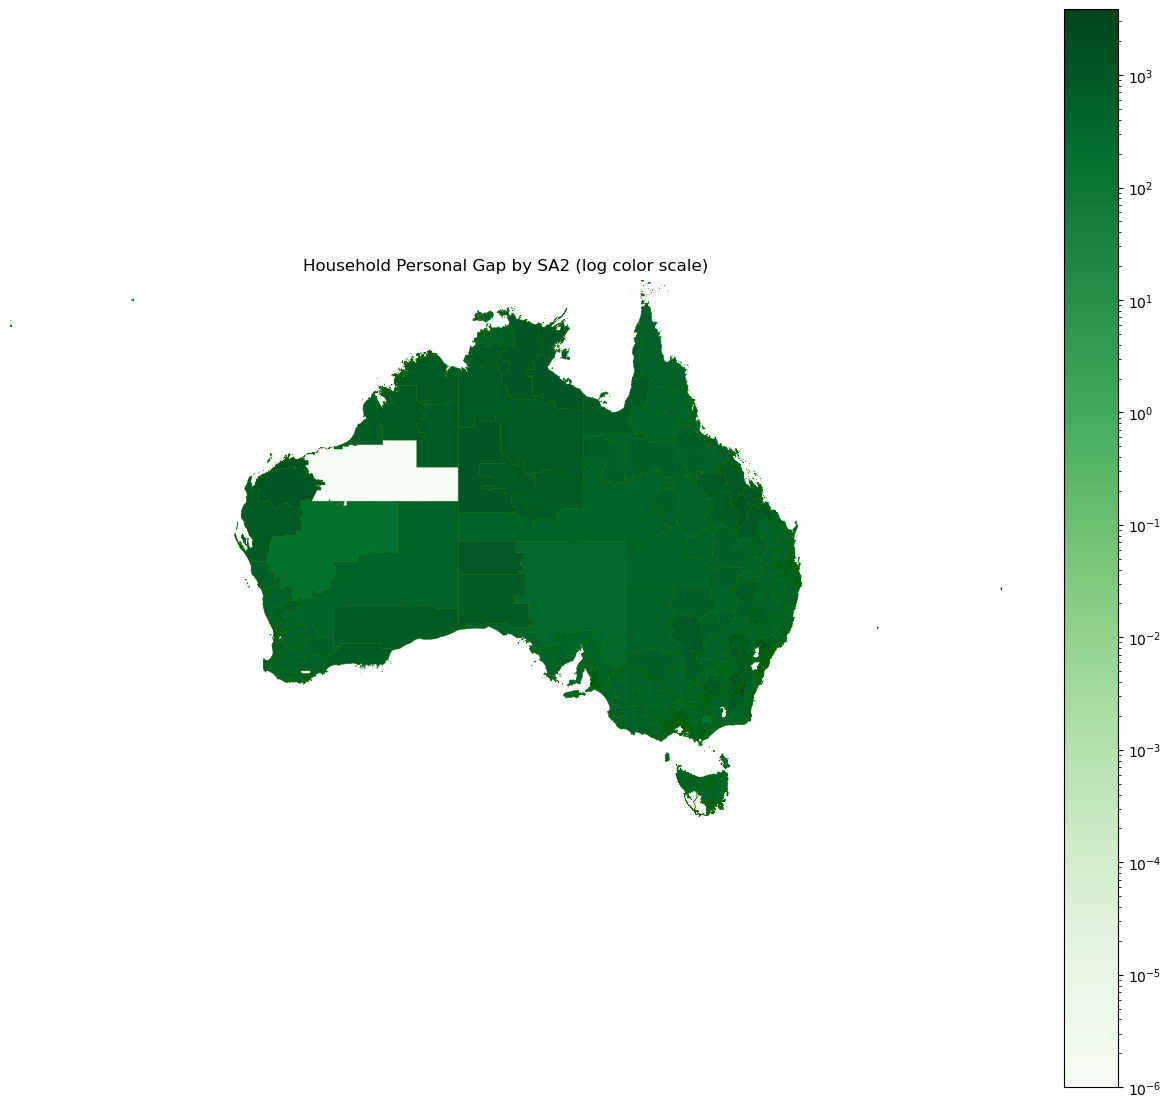

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(16, 14))
vals3 = pd.to_numeric(merged["household_personal_gap"], errors="coerce").fillna(0).clip(lower=eps)
merged.plot(
    column=vals3, cmap="Greens",
    norm=LogNorm(vmin=max(vals3[vals3>0].min(), eps), vmax=vals3.max()),
    linewidth=0.3, edgecolor="darkgreen", legend=True, ax=ax
)
ax.set_title("Household Personal Gap by SA2 (log color scale)")
ax.axis("off")
xmin, ymin, xmax, ymax = merged.total_bounds
ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
plt.show()

#### Static map of median personal income by SA2

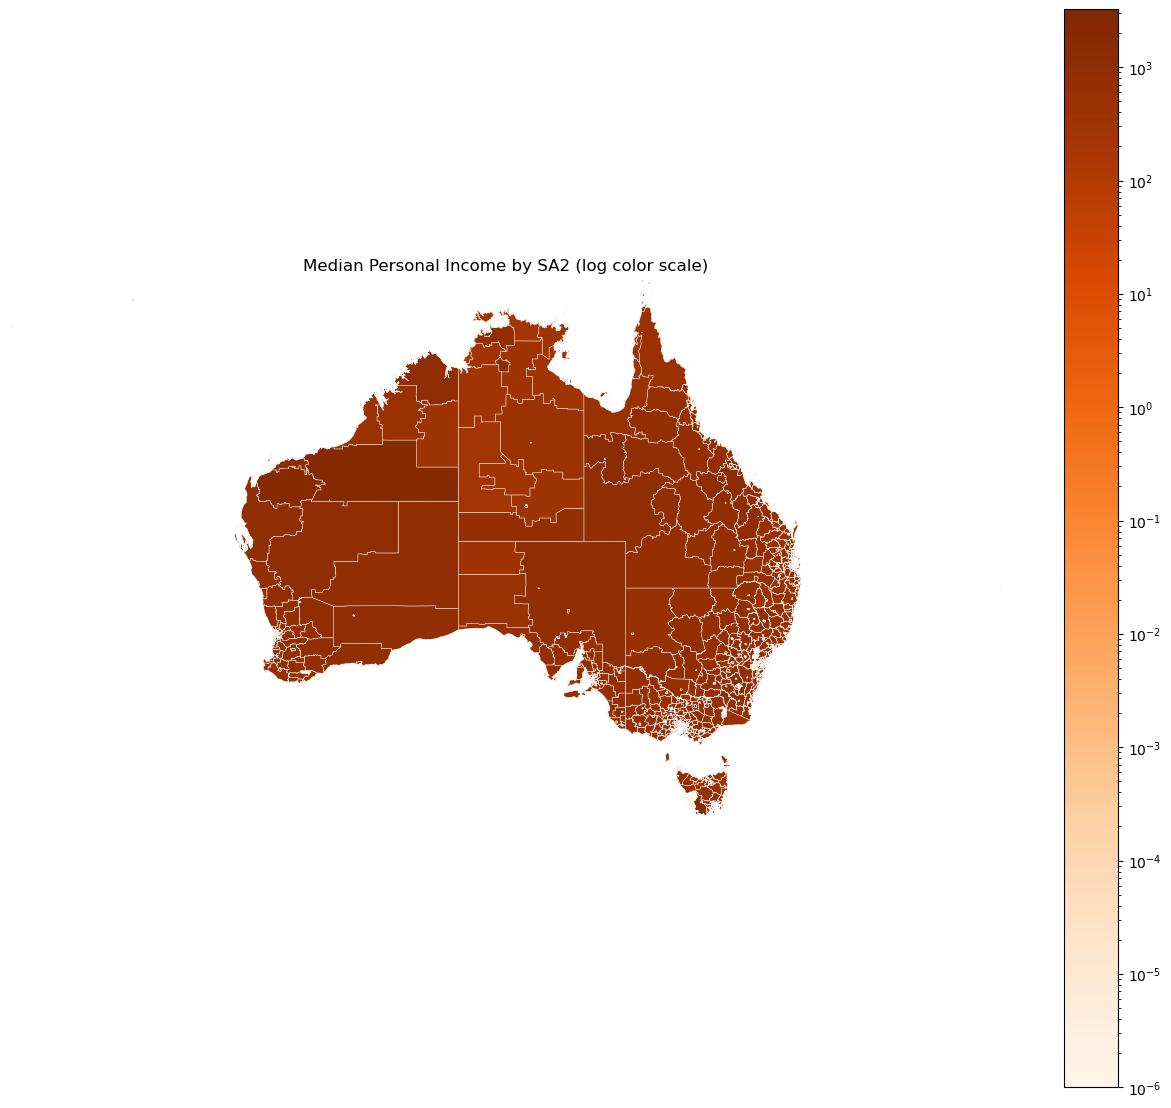

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(16, 14))
vals4 = pd.to_numeric(merged["median_weekly_personal_income"], errors="coerce").fillna(0).clip(lower=eps)
merged.plot(
    column=vals4, cmap="Oranges",
    norm=LogNorm(vmin=max(vals4[vals4>0].min(), eps), vmax=vals4.max()),
    linewidth=0.3, edgecolor="white", legend=True, ax=ax
)
ax.set_title("Median Personal Income by SA2 (log color scale)")
ax.axis("off")
xmin, ymin, xmax, ymax = merged.total_bounds
ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
plt.show()

## Final Features

In [28]:
final = merged.loc[:, [c for c in ["SA2_code", "SA2_name", "state_code", "state_name", "geometry", "median_weekly_personal_income", "household_personal_gap", "dependency_ratio", "pct_youth", "pct_seniors", "unemployment_rate", "full_time_share", "part_time_share"] if c in merged.columns]]

In [29]:
final.head()

,SA2_code,SA2_name,state_code,state_name,geometry,median_weekly_personal_income,household_personal_gap,dependency_ratio,pct_youth,pct_seniors,unemployment_rate,full_time_share,part_time_share
0,101021007,Braidwood,1,New South Wales,"POLYGON ((149.58424 -35.44426, 149.58444 -35.4...",760.0,669.0,0.721235,0.028091,0.253511,0.032536,0.558852,0.328230
1,101021008,Karabar,1,New South Wales,"POLYGON ((149.21899 -35.36738, 149.218 -35.366...",975.0,1014.0,0.512602,0.060467,0.145474,0.043922,0.648181,0.248669
2,101021009,Queanbeyan,1,New South Wales,"POLYGON ((149.21326 -35.34325, 149.21619 -35.3...",996.0,707.0,0.459081,0.060748,0.160906,0.041398,0.652101,0.254370
3,101021010,Queanbeyan - East,1,New South Wales,"POLYGON ((149.24034 -35.34781, 149.24024 -35.3...",1104.0,692.0,0.390026,0.067453,0.126057,0.035608,0.676558,0.237389
4,101021012,Queanbeyan West - Jerrabomberra,1,New South Wales,"POLYGON ((149.19572 -35.36126, 149.1997 -35.35...",1357.0,1657.0,0.451543,0.058537,0.096045,0.022466,0.669486,0.256641


## Save to CSV

In [30]:
final.to_csv(CUR / "gcp_merged_cleaned.csv", index=False, float_format="%.6f")

## Summary of EDA

**1. Summary Statistics**
- Population (total_population): wide variation (mean ≈ 10.5k, max 28k). Some very small SA2s (min = 3) might be special cases (remote/industrial zones). These tiny areas can distort ratios.
- Incomes:
    - Personal income: mean ≈ $844/week, but some 0 values exist (likely suppressed data). Outliers up to $3,250.
    - Household income: mean ≈ $1,782/week, with some 0 values. Gap (household/personal) has a mean ≈ 2.13 but extreme outliers (up to 12).
- Age structure:
    - Children ~15%, youth ~6%, young adults ~14%, adults ~38%, seniors ~17%.
- Ratios sum to ~1 as expected. Outliers exist (youth share up to 77%, clearly a student-dominated SA2).
- Labour force shares:
- Full-time share ~56%, part-time share ~31%, unemployment rate mean ~5.2% but with extreme outliers up to 133% (clearly data error or small denominators in tiny SA2s).
- Dependency ratio: mean ~0.58 but outliers up to 4.3 (areas with high seniors/children vs. very few working adults).
- Income per worker: mean ~3.8 but huge standard deviation, outliers up to 812. Likely meaningless because it divides median income by total labour force (scale mismatch).
2. **Distribution Plots**
- Most socio-economic variables (income, shares, dependency) are right-skewed.
- Unemployment heavily skewed with many near 0 but a long tail of outliers.
- Dependency ratio has a normal-ish cluster ~0.5–0.7 but extreme high values.
- Percentages (children, youth, adults, seniors) show clear peaks, but with some implausible outliers (e.g., >70% youth).
3. **Outlier Checks**
- Unemployment: many extreme points >40%, clearly unrealistic for large populations → may be from small-pop SA2s.
- Personal income: outliers above $2,500/week are rare but could reflect mining-rich regions.
- Dependency ratio: values >2 are extreme (likely SA2s with universities or retirement-heavy communities).
4. **Correlations**
- Strong correlations:
    - Personal vs. household income (0.74) → redundant, you could keep one or derive gap.
    - Dependency ratio vs. pct_seniors (0.82) → seniors drive dependency.
    - Youth vs. young adults (0.53).
- Negative correlations:
    - Income vs. dependency ratio (-0.34 to -0.40).
    - Young adults vs. seniors (-0.56).
    - Part-time share vs. full-time share (-0.49) — expected since they sum to ~1.
5. **Scatterplots**
- Youth vs. Unemployment: slight positive relationship in youth-heavy areas → consistent with BNPL risk hypothesis.
- Seniors vs. Household gap: weak positive trend — areas with many seniors tend to have higher household-to-personal income ratios (multi-earner families supporting older adults).
- Income vs. Unemployment: clear negative correlation — richer areas have lower unemployment.
- Income per worker vs. not in labour force: mostly noisy; feature may not be reliable.
6. **Geographical patterns**
- Unemployment Rate by SA2
    - Observation: Most metropolitan and coastal areas show relatively low unemployment (light colors), while remote/inner-regional SA2s in Northern Territory, Queensland, and WA show darker shades.
    - Outliers: A few SA2s have unusually high unemployment (>1.0 = 100%+, likely denominator issue in small labour forces). These are mostly tiny-population remote SA2s.
    - BNPL implication: Higher unemployment clusters suggest financial vulnerability in remote communities → potential higher BNPL reliance.
- Dependency Ratio by SA2
    - Observation: Ratios are generally moderate (0.4–0.8), but some SA2s spike above 2–4 (more dependents than working-age adults). These extremes are in sparsely populated regions, aged communities, or child-heavy areas.
    - Spatial pattern: Regional QLD, NT, and rural NSW show higher dependency ratios, while urban cores (Sydney, Melbourne, Brisbane) show balanced ratios.
    - BNPL implication: High dependency areas → higher financial strain on earners → increased credit risk.
- Household–Personal Income Gap (Ratio)
    - Observation: Gaps are higher in resource/mining-dominated SA2s (WA, NT), where households often have multiple high earners. Coastal cities are more balanced.
    - Interpretation: This metric captures household multi-earner capacity. High gaps = households rely on multiple incomes, which could mask individual vulnerability if one income is lost.
    - BNPL implication: Areas with high household-personal gaps may have “fragile” financial resilience → BNPL use could spike if one earner loses income.
- Median Personal Income
    - Observation: Big city cores (Sydney, Melbourne, Perth, Canberra) show high personal incomes, while inland/regional areas lag behind.
    - Extremes: Mining and capital city SA2s dominate the top, while rural/remote SA2s have much lower medians.
    - BNPL implication: Low-income SA2s are prime candidates for BNPL adoption due to affordability issues; high-income SA2s may still use BNPL, but more for convenience than necessity.

**Feature Selection — What to Keep / Drop**
- Features to Keep (core drivers of BNPL relevance)
    - median_weekly_personal_income
        - Why keep: Strong affordability proxy at the individual level, directly tied to ability to service BNPL debt. Outlier variation (e.g., mining towns) also captures meaningful regional inequality.
        - BNPL link: Lower incomes = higher financial stress → more reliance on BNPL.
    - household_personal_gap
        - Why keep: Captures multi-earner reliance — a unique signal not visible in personal or household income alone. Large gaps mean households look wealthy but are vulnerable if a single earner drops out.
        - BNPL link: Fragile financial resilience → BNPL can mask short-term shocks.
    - dependency_ratio
        - Why keep: Summarises financial burden per worker (children + seniors vs. working-age). More interpretable and stronger than keeping pct_seniors/pct_children separately.
        - BNPL link: More dependents = more financial stress = higher BNPL risk.
    - pct_youth (20–24)
        - Why keep: Youth are the primary BNPL demographic (marketing, adoption).
        - BNPL link: Higher youth share predicts BNPL usage regardless of income.
    - pct_seniors
        - Why keep: Older-heavy communities often face fixed incomes + medical costs. Useful for contrasting with youth-heavy areas.
        - BNPL link: Seniors may not directly adopt BNPL, but high pct_seniors → greater dependency burden on younger earners.
    - unemployment_rate
        - Why keep: Direct proxy for financial distress. Outliers (e.g., remote regions with high unemployment) are meaningful risk markers.
        - BNPL link: Unemployment drives short-term credit reliance.
    - full_time_share & part_time_share
        - Why keep: Capture underemployment dynamics beyond just unemployment. Part-time dominance can signal precarious work.
        - BNPL link: Part-time/underemployed households may turn to BNPL to smooth consumption.
- Features to Drop (redundant, weak, or unstable)
    - median_weekly_household_income
        - Drop because: Highly correlated with personal income (ρ ≈ 0.74). Better to keep personal income + household_personal_gap instead of both raw.
    - pct_children & pct_teenagers
        - Drop because: Weak direct BNPL connection (kids don’t use BNPL themselves). Effects already rolled into dependency_ratio.
    - pct_adults
        - Drop because: Redundant (complements dependency ratio, but adds little new info).
    - income_per_worker
        - Drop because: Scale mismatch — dividing median income by labour force created extreme outliers (mean ≈ 3.8 vs. max 812). Not interpretable.
    - pct_unemployed, pct_labour_force, pct_not_in_labour_force
        - Drop because: Redundant. These are population-based versions of labour metrics, but unemployment_rate + shares already capture the same insight more clearly.
    - Interactions (youth_x_unemployment, dependency_x_unemployment, hhgap_x_seniors)
        - Drop unless hypothesis-driven: They’re highly correlated with their main features. Keep them only if you want to test non-linear BNPL effects explicitly. Otherwise, they risk adding multicollinearity.
    - part_time_share OR full_time_share (drop one)
        - Drop because: They’re inversely correlated (-0.49). Keeping both adds redundancy. You can keep full_time_share as the stronger baseline, or use both if you want to model underemployment explicitly.